In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

# How many different cases are there, by department?

Text(0.5, 1.0, 'Types of Cases By Department')

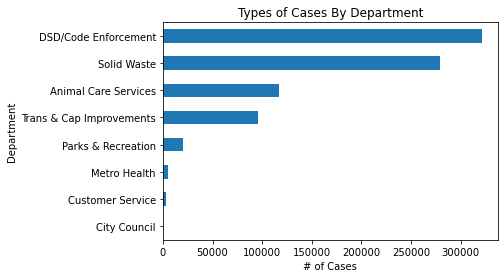

In [2]:
(df.groupBy('department').count().toPandas()
     .set_index('department')['count'].sort_values()
     .plot.barh())
plt.xlabel('# of Cases')
plt.ylabel('Department')
plt.title('Types of Cases By Department')

# Does the percentage of cases that are late vary by department?

Text(0.5, 1.0, 'On Average, Which Cases Are Latest?')

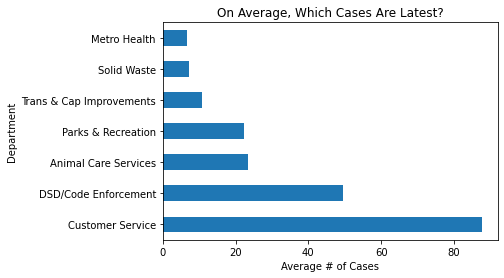

In [3]:
(df.where('case_late').groupBy('department').agg(avg('num_days_late').alias('avg_days_late'))
    .toPandas().set_index('department')['avg_days_late'].sort_values(ascending=False)
    .plot.barh())
plt.ylabel("Department")
plt.xlabel("Average # of Cases")
plt.title("On Average, Which Cases Are Latest?")

# On average, how late are the late cases by department?

Text(0.5, 1.0, '10 Latest Services')

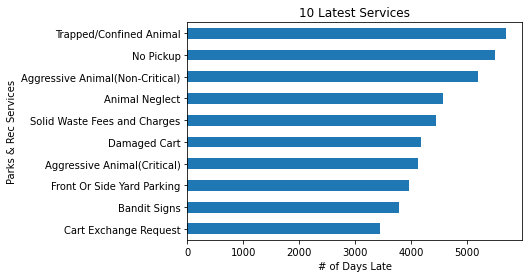

In [4]:
(df.where('case_late').groupBy('service_request_type').agg(count('num_days_late').alias('days_late'))
    .toPandas().set_index('service_request_type')['days_late'].sort_values().tail(10)
    .plot.barh())
plt.ylabel("Parks & Rec Services")
plt.xlabel("# of Days Late")
plt.title("10 Latest Services")

# What is the service type that is the most late? Just for Parks & Rec?

Text(0.5, 1.0, 'Most Common DSD/CE Department Requests')

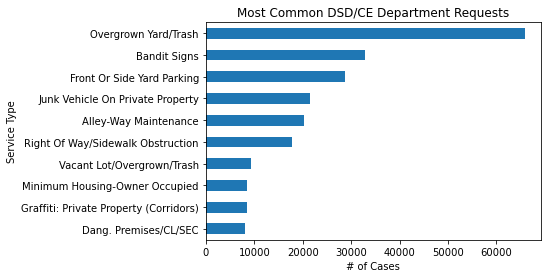

In [5]:
(df.where(col('department') == 'DSD/Code Enforcement').groupBy('service_request_type').count().sort(('count'))
    .toPandas().set_index('service_request_type')['count'].tail(10)
    .plot.barh())
plt.ylabel("Service Type")
plt.xlabel("# of Cases")
plt.title("Most Common DSD/CE Department Requests")

# For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

Text(0.5, 1.0, 'Most Common Animal Care Services Requests')

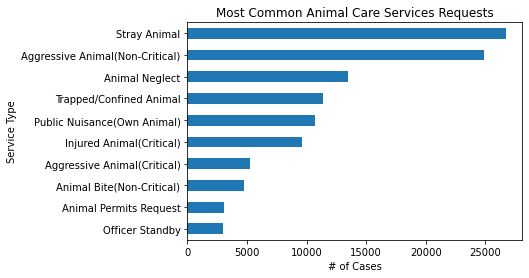

In [6]:
(df.where(col('department') == 'Animal Care Services').groupBy('service_request_type').count().sort(('count'))
    .toPandas().set_index('service_request_type')['count'].tail(10)
    .plot.barh())
plt.ylabel("Service Type")
plt.xlabel("# of Cases")
plt.title("Most Common Animal Care Services Requests")

# Does whether or not its a weekend matter for when a case is opened/closed?

Text(0.5, 1.0, 'Number of Closed Cases')

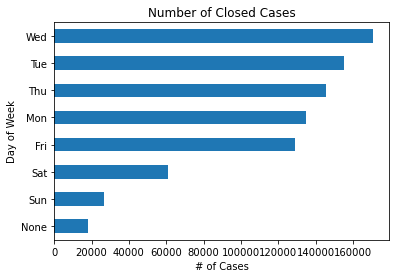

In [7]:
(df.withColumn("week_day", date_format(col("case_closed_date"), "E")).groupBy('week_day').count().sort('count')
    .toPandas().set_index('week_day')['count']
    .plot.barh())
plt.ylabel("Day of Week")
plt.xlabel("# of Cases")
plt.title("Number of Closed Cases")

Text(0.5, 1.0, 'Number of Opened Cases')

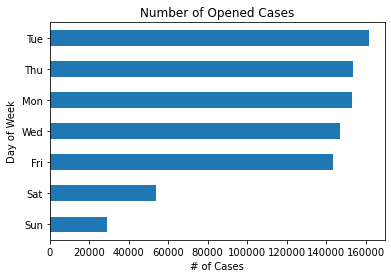

In [8]:
(df.withColumn("week_day", date_format(col("case_opened_date"), "E")).groupBy('week_day').count().sort('count')
    .toPandas().set_index('week_day')['count']
    .plot.barh())
plt.ylabel("Day of Week")
plt.xlabel("# of Cases")
plt.title("Number of Opened Cases")

# On average, how many cases are opened a day for the Customer Service department?

In [9]:
print('The average number of cases opened daily in the Customer Service Department is',
    (df.where(col("department") == "Customer Service")
    .select(date_format("case_opened_date", "yyyy-MM-dd").alias("case_opened_date"))
    .groupBy('case_opened_date').count().sort('case_opened_date')
    .toPandas().assign(case_opened_date=lambda df: pd.to_datetime(df.case_opened_date))
    .set_index('case_opened_date')['count'].mean()))

The average number of cases opened daily in the Customer Service Department is 5.564453125


# Does the number of service requests for the solid waste department vary by day of the week?

Text(0.5, 1.0, 'Number of Solid Waste Department Requests')

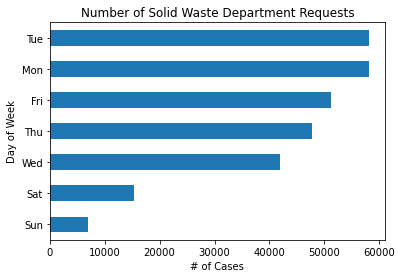

In [10]:
(df.withColumn("week_day", date_format(col("case_opened_date"), "E")).where(col('department') == 'Solid Waste')
    .groupBy('week_day').count().na.drop().sort('count').toPandas().set_index('week_day')['count']
    .plot.barh())
plt.ylabel("Day of Week")
plt.xlabel("# of Cases")
plt.title("Number of Solid Waste Department Requests")